In [1]:
import numpy as np
from scipy.sparse.linalg import eigs
from scipy.linalg import eigh
from numpy import linalg as LA
from scipy.interpolate import Akima1DInterpolator
from scipy.linalg import expm
import time
from scipy import sparse
import matplotlib.pyplot as plt
import pandas
import scipy

np.set_printoptions(precision=6)
# initialize variables
N = 8
# Q is the dimension
Q = pow(2, N)

# decimal number to binary array function
def D2B(num, digit):
    string = f'{num:0{digit}b}'
    result = np.array([int(ele) for ele in string], int)
    return result
# binary array to decimal function
def B2D(array):
    res = 0
    for ele in array:
        res = (res << 1) | ele
    return res

def spin_reflection(array):
    return 1 - array  # Flip each spin (1 -> 0, 0 -> 1)

def spatial_reflection(array):
    new_array = array[::-1]
    return new_array


In [2]:
###########################
B = 0.1  # Initial B value
B_not = 10
###########################

In [3]:
#t_f = 11980
# J_matrix= np.array([[0.0, -0.770026, -0.612588, 1.884469, -0.570562, 0.616424, 1.663316, -0.448101],
#                                          [0.0, 0.0, 0.795786, 0.693566, -1.818596, -1.793477, 0.869296, -0.476921],
#                                          [0.0, 0.0, 0.0, 1.166175, 2.639218, 0.896904, -0.685189, 0.523481],
#                                          [0.0, 0.0, 0.0, 0.0, 1.069138, 0.163168, 0.637887, 0.75839],
#                                          [0.0, 0.0, 0.0, 0.0, 0.0, 1.210793, 0.186866, 0.464955],
#                                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -2.255085, -1.129867],
#                                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.741586],
#                                          [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])


#  Rank 3: t_f = 493.01095833740817, E_c = 0.008849508983285403, B_c = 0.215
# J_matrix = np.array([[0.000000, 0.773813, 2.485213, -0.561542, 0.008873, 0.691680, 0.086291, -0.564034], [0.000000, 0.000000, 1.397455, -0.112515, 0.388229, -1.835349, 1.372802, 0.738212], [0.000000, 0.000000, 0.000000, -0.169025, 0.746900, -1.199308, 0.269533, -1.233924], [0.000000, 0.000000, 0.000000, 0.000000, 0.939910, 0.653794, 1.202234, 0.980422], [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, -1.008154, 2.553466, 0.876100], [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.196304, -0.398031], [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.282909], [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000]])

In [11]:
# # initialize J matrix
# J_matrix = np.zeros((N, N), dtype='float64')
# for i in range(N):
#     for j in range(N):
#         if j >= (i + 1):
#             J_matrix[i][j] = 1/pow(abs(i-j),1)

In [10]:
# working in the full matrix

# Initialize the Hamiltonian components
H_a = np.zeros(Q)  # Interaction term (ZZ term), diagonal only
HB_matrix = np.zeros((Q, Q))  # Transverse field term (X term)

# Construct the Hamiltonian
for state in range(Q):
    basis = D2B(state, N)

    # Transverse field term (X term)
    for i in range(N):
        flipped_basis = basis.copy()
        flipped_basis[i] = 1 - flipped_basis[i]  # Flip the i-th spin
        new_state = B2D(flipped_basis)
        HB_matrix[state, new_state] += 1  # Coefficient will be multiplied by B later

    # Interaction term (ZZ term)
    for i in range(N):
        for j in range(i + 1, N):
            J_ij = J_matrix[i][j]
            H_a[state] += J_ij * (1 if basis[i] == basis[j] else -1)

# Convert H_a to a diagonal matrix
HA_matrix = np.diag(H_a)

# # # Full Hamiltonian
# H = HA_matrix + 0.1 * HB_matrix

# # Diagonalize the Hamiltonian
# eigenvalues, eigenvectors = np.linalg.eigh(H)

# # Ground state energy
# gs_energy = eigenvalues[0]

# # Display the Hamiltonian matrix and ground state energy
# print("Hamiltonian matrix:\n", H)
# print("\nGround state energy:", gs_energy)

In [5]:
# # looking for spin parity value

# # Compute spin parity for each eigenstate
# spin_parities = []

# # Loop over each eigenstate
# for vec_idx in range(0,5):
#     eigenstate = eigenvectors[:, vec_idx]  # Extract the eigenstate vector (column of eigenvectors matrix)

#     # Apply spin reflection to each basis state
#     parity_sum = 0  # Initialize the parity sum for the current eigenstate
#     for basis_idx in range(Q):  # Loop over all basis states
#         basis = D2B(basis_idx, N)  # Convert basis index to binary representation
#         reflected_basis = spin_reflection(basis)  # Apply spin reflection to the basis state
#         reflected_idx = B2D(reflected_basis)  # Convert the reflected basis back to a decimal index

#         # Calculate the parity by comparing original and reflected amplitudes
#         parity_sum += eigenstate[basis_idx] * eigenstate[reflected_idx]
#         #print(parity_sum)
#     spin_parities.append(parity_sum)  # Store the computed parity for the current eigenstate


# # Display results
# for idx, parity in enumerate(spin_parities):
#     print(f"Eigenstate {idx + 1}: Spin Parity = {parity:.6f}")


In [6]:
def calculate_spin_parity(eigenvector):
    parity_sum = 0  # Initialize the parity sum for the current eigenvector
    for basis_idx in range(Q):  # Loop over all basis states
        basis = D2B(basis_idx, N)  # Convert basis index to binary representation
        reflected_basis = spin_reflection(basis)  # Apply spin reflection to the basis state
        reflected_idx = B2D(reflected_basis)  # Convert the reflected basis back to a decimal index

        # Calculate the parity by comparing original and reflected amplitudes
        parity_sum += eigenvector[basis_idx] * eigenvector[reflected_idx]

    return round(parity_sum, 5)  # Round to 5 digits

In [7]:
# checking code
# Full Hamiltonian
# B = 0.1  # Example value for transverse field strength
# H = HA_matrix + B * HB_matrix  # Combine ZZ and X terms to construct the full Hamiltonian

# # Diagonalize the Hamiltonian
# eigenvalues, eigenvectors = eigh(H)  # Use eigh for diagonalizing the Hermitian matrix H
# print(eigenvalues[0])
# # Compute spin parity for each eigenstate
# spin_parities = []

# # Loop over each eigenstate and calculate its spin parity
# for vec_idx in range(10):
#     eigenstate = eigenvectors[:, vec_idx]  # Extract the eigenstate vector (column of eigenvectors matrix)
#     parity = calculate_spin_parity(eigenstate)  # Calculate the spin parity for the current eigenstate
#     spin_parities.append(parity)  # Store the computed parity for the current eigenstate
# print(spin_parities)

In [8]:
# Start looping for different B values
dB = 0.0001  # Step size for B
B_not = 10  # Example maximum value for B
B_value_list = np.arange(B, B_not, dB)  # Generate list of B values
#
# B_value_list = np.array([0.1,1])

num_matching_states = 5  # Number of matching excited states to find
delta_e_lists = [[] for _ in range(num_matching_states)]  # List to store energy gaps for matching states

for B_value in B_value_list:
    H_matrix = HA_matrix + B_value * HB_matrix  # Update Hamiltonian with current B value
    vals, vecs = eigh(H_matrix)  # Diagonalize the Hamiltonian

    # Get ground state parity
    gs_parity = calculate_spin_parity(vecs[:, 0])
    #print(gs_parity)
    # Find the first few excited states with the same parity as the ground state
    matching_indices = []
    for i in range(1, Q):
        if calculate_spin_parity(vecs[:, i]) == gs_parity:
            matching_indices.append(i)
        if len(matching_indices) >= num_matching_states:
            break
    #print(matching_indices)
    # Calculate energy gaps for the matching states
    for idx, matching_index in enumerate(matching_indices):
        delta_energy = vals[matching_index] - vals[0]
        delta_e_lists[idx].append(delta_energy)

# Display results
# for idx, parity in enumerate(spin_parities):
#     print(f"Eigenstate {idx + 1}: Spin Parity = {parity:.6f}")  # Print the parity value for each eigenstate

In [9]:
# NOTE, lA field data is included in Fig_1 folder , here provide how to get the energy spectrum

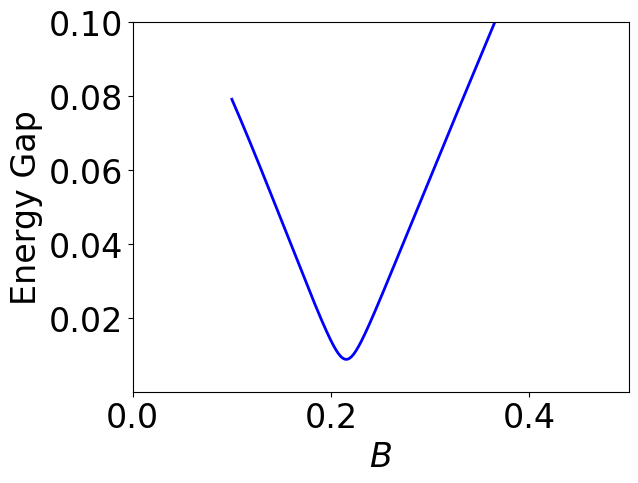

In [16]:
# Plotting the energy gaps for the matching states
delta_e_arrays = [np.array(delta_e_list) for delta_e_list in delta_e_lists]

fig, ax = plt.subplots()
colors = ['blue', 'green', 'orange', 'purple', 'brown']
labels = [f'Matching State {i + 1}' for i in range(num_matching_states)]

for idx, delta_e_array in enumerate(delta_e_arrays):
    linestyle = '--' if idx > 0 else '-'
    ax.plot(B_value_list, delta_e_array, linestyle=linestyle, lw=2, color=colors[idx % len(colors)], label=labels[idx])

ax.set(xlabel=r'$B$', ylabel='Energy Gap')
# Increase the font size of the labels
ax.tick_params(axis='both', labelsize=24)
# Set the font size for the axis labels
label_size = 24
ax.xaxis.label.set_fontsize(label_size)  # Adjust the font size for the x-axis label
ax.yaxis.label.set_fontsize(label_size)  # Adjust the font size for the y-axis label

# # Add legend
# ax.legend(fontsize=16)

# Set axis limits
ax.set_xlim(0,0.5)
ax.set_ylim(0.0001,0.1)

# # Plot B critical
# plt.vlines(0.05, 0, 6, color='red', lw=2)

# Save and show the plot
plt.savefig('B_vs_energy_gap_tf_493.png', bbox_inches='tight')
plt.show()

In [15]:
import pandas as pd
delta_e_dict = {f'd{i + 1}': delta_e_arrays[i] for i in range(num_matching_states)}
df = pd.DataFrame(data={'B': B_value_list, **delta_e_dict})
df.to_csv('energy_spec_tf_493.csv', sep=',', index=False)

In [12]:
# Calculate total ramp time t_f for locally adiabatic evolution
gamma = 1  # Set gamma to be 1
one_over_delta_square = 1 / np.square(delta_e_arrays[0])  # Calculate 1 / delta^2 for the first matching state
t_f = gamma * np.trapz(one_over_delta_square, x=B_value_list)  # Use trapezoidal integration to calculate t_f
print('t_f is ', t_f)

t_f is  493.01116377161367


In [13]:
np.min(delta_e_arrays)

0.008846979172487224

In [14]:
B_value_list[np.argmin(delta_e_arrays)]

0.21530000000000332